Quantitative Methods Report

# Introduction

Stop and Search rate and how it is related to London lokdowns and deprivation.

# Analysis

## Load packages, define projections and load data

In [3]:
pip install researchpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
%matplotlib inline

# for modelling
from patsy import dmatrices
import statsmodels.api as sm
import researchpy as rp
import scipy.stats as stats


In [5]:
# define coordinates
from pyproj import CRS

wgs84 = CRS(4326)
bng = CRS(27700)

print(wgs84)
bng

epsg:4326


<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [6]:
search1 = pd.read_csv('April2020.csv') 
search2 = pd.read_csv('April2019.csv')
deprivation_data = gpd.read_file('English IMD 2019/English IMD 2019/IMD_2019.shp')

In [7]:
print(len(search1))
len(search2)

30583


20818

In [8]:
deprivation_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lsoa11cd    32844 non-null  object  
 1   lsoa11nm    32844 non-null  object  
 2   lsoa11nmw   32844 non-null  object  
 3   st_areasha  32844 non-null  float64 
 4   st_lengths  32844 non-null  float64 
 5   IMD_Rank    32844 non-null  int64   
 6   IMD_Decile  32844 non-null  int64   
 7   LSOA01NM    32844 non-null  object  
 8   LADcd       32844 non-null  object  
 9   LADnm       32844 non-null  object  
 10  IMDScore    32844 non-null  float64 
 11  IMDRank0    32844 non-null  int64   
 12  IMDDec0     32844 non-null  int64   
 13  IncScore    32844 non-null  float64 
 14  IncRank     32844 non-null  int64   
 15  IncDec      32844 non-null  int64   
 16  EmpScore    32844 non-null  float64 
 17  EmpRank     32844 non-null  int64   
 18  EmpDec      32844 non-null  int64   
 

## Data preparation/processing

1. Isolate the variables we want to use for modelling
2. Create dummy variable for a year in each stop & search
3. Combine the stop & search data
4. Clean up the variables (NA, 0,...)
5. Spatial manipulation, to get ready for aditional modelling
6. Group by lsoa to get ready for first modelling

### 1. Isolating variables for model making

In [11]:
# IMD score is most suitable for regressions

IMD = deprivation_data.loc[:,['lsoa11cd', 'LADcd','IMDScore','EmpScore','EduScore','HDDScore','CriScore','EnvScore','CYPScore','TotPop','Pop16_59','WorkPop','geometry']]
# CYPscore = Children and Young People Sub-domain Score,  measures the attainment of qualifications and associated measures. It is one of two sub-domains of the Education, Skills and Training Deprivation domain

# IMDDec0 = decila % the higher number the less deprivation
# IMDScore = score float, lower the number the less deprived area
# IMDRank0 = Rank  1 (most deprived area) to 32,844 (least deprived area)
IMD.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lsoa11cd  32844 non-null  object  
 1   LADcd     32844 non-null  object  
 2   IMDScore  32844 non-null  float64 
 3   EmpScore  32844 non-null  float64 
 4   EduScore  32844 non-null  float64 
 5   HDDScore  32844 non-null  float64 
 6   CriScore  32844 non-null  float64 
 7   EnvScore  32844 non-null  float64 
 8   CYPScore  32844 non-null  float64 
 9   TotPop    32844 non-null  int64   
 10  Pop16_59  32844 non-null  int64   
 11  WorkPop   32844 non-null  float64 
 12  geometry  32844 non-null  geometry
dtypes: float64(8), geometry(1), int64(2), object(2)
memory usage: 3.3+ MB


In [12]:
search2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20818 entries, 0 to 20817
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Type                                      20818 non-null  object 
 1   Date                                      20818 non-null  object 
 2   Part of a policing operation              20818 non-null  bool   
 3   Policing operation                        0 non-null      float64
 4   Latitude                                  18834 non-null  float64
 5   Longitude                                 18834 non-null  float64
 6   Gender                                    20580 non-null  object 
 7   Age range                                 18879 non-null  object 
 8   Self-defined ethnicity                    20579 non-null  object 
 9   Officer-defined ethnicity                 20461 non-null  object 
 10  Legislation                       

In [13]:
# crime data
CRIME19 = search2.loc[:,['Type','Latitude', 'Longitude', 'Gender', 'Age range', 'Self-defined ethnicity', 'Officer-defined ethnicity','Object of search', 'Outcome']]
CRIME20 = search1.loc[:,['Type','Latitude', 'Longitude', 'Gender', 'Age range', 'Self-defined ethnicity','Officer-defined ethnicity', 'Object of search', 'Outcome']]

In [14]:
print(len(CRIME19))
len(CRIME20)

20818


30583

### 2. Create dummy variable for a year

In [15]:
CRIME20['lockdown'] = 1 # 2020
CRIME19['lockdown'] = 0 # 2019

### 3. Combine the crime data

In [16]:
CRIME = pd.concat([CRIME19, CRIME20])
CRIME.head()

,Type,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Object of search,Outcome,lockdown
0,Person search,51.404301,-0.101673,Male,25-34,Other ethnic group - Not stated,Asian,Offensive weapons,A no further action disposal,0
1,Person search,51.398906,-0.098374,Male,18-24,Other ethnic group - Not stated,Asian,Offensive weapons,Arrest,0
2,Person search,51.565908,-0.010526,Male,18-24,Black/African/Caribbean/Black British - African,Black,Controlled drugs,Community resolution,0
3,Person search,51.351657,-0.022780,Female,10-17,Black/African/Caribbean/Black British - Any ot...,Black,Stolen goods,Arrest,0
4,Person search,51.538688,0.052054,Male,over 34,Black/African/Caribbean/Black British - African,Black,Controlled drugs,A no further action disposal,0


### 4. Clean up the variables (NA, 0,...)

#### Crime clean-up

In [17]:
# get rid of the spaces in names and capital cases
CRIME.columns = CRIME.columns.str.lower().str.replace(' ', '_')
CRIME.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51401 entries, 0 to 30582
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       51401 non-null  object 
 1   latitude                   46412 non-null  float64
 2   longitude                  46412 non-null  float64
 3   gender                     50689 non-null  object 
 4   age_range                  46658 non-null  object 
 5   self-defined_ethnicity     50690 non-null  object 
 6   officer-defined_ethnicity  50378 non-null  object 
 7   object_of_search           51283 non-null  object 
 8   outcome                    51401 non-null  object 
 9   lockdown                   51401 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 4.3+ MB


In [18]:
# Doe this increased the number of outcomes?
# Dataset where we look at all stop and seraches
all_seraches = CRIME.copy()

# Dataset loking only at the outcomes
CRIME.outcome.unique()
list_action = CRIME['outcome'].unique()
list_action = list_action[1:7]

CRIME = CRIME.loc[CRIME['outcome'].isin(list_action)].reindex()

CRIME.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11903 entries, 1 to 30579
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       11903 non-null  object 
 1   latitude                   10850 non-null  float64
 2   longitude                  10850 non-null  float64
 3   gender                     11683 non-null  object 
 4   age_range                  11452 non-null  object 
 5   self-defined_ethnicity     11687 non-null  object 
 6   officer-defined_ethnicity  11636 non-null  object 
 7   object_of_search           11856 non-null  object 
 8   outcome                    11903 non-null  object 
 9   lockdown                   11903 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 1022.9+ KB


In [19]:
all_seraches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51401 entries, 0 to 30582
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       51401 non-null  object 
 1   latitude                   46412 non-null  float64
 2   longitude                  46412 non-null  float64
 3   gender                     50689 non-null  object 
 4   age_range                  46658 non-null  object 
 5   self-defined_ethnicity     50690 non-null  object 
 6   officer-defined_ethnicity  50378 non-null  object 
 7   object_of_search           51283 non-null  object 
 8   outcome                    51401 non-null  object 
 9   lockdown                   51401 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 4.3+ MB


In [20]:
a = len(all_seraches.loc[all_seraches['lockdown'] == 1,])
b = len(all_seraches.loc[all_seraches['lockdown'] == 0,])

In [21]:
a-b

9765

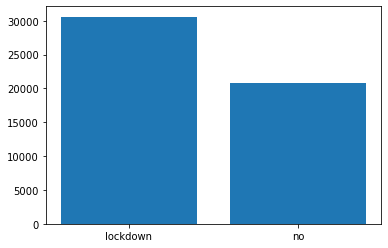

In [22]:
# Make a fake dataset:
height = [a,b]
bars = ('lockdown', 'no')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()


In [23]:
# check NA
CRIME.isna().sum()

type                            0
latitude                     1053
longitude                    1053
gender                        220
age_range                     451
self-defined_ethnicity        216
officer-defined_ethnicity     267
object_of_search               47
outcome                         0
lockdown                        0
dtype: int64

In [24]:
all_seraches.isna().sum()

type                            0
latitude                     4989
longitude                    4989
gender                        712
age_range                    4743
self-defined_ethnicity        711
officer-defined_ethnicity    1023
object_of_search              118
outcome                         0
lockdown                        0
dtype: int64

In [25]:
# get rid of the data we cant spatially localize
CRIME = CRIME.loc[CRIME.latitude.notnull()]
all_seraches = all_seraches.loc[all_seraches.latitude.notnull()]

CRIME.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10850 entries, 1 to 30579
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       10850 non-null  object 
 1   latitude                   10850 non-null  float64
 2   longitude                  10850 non-null  float64
 3   gender                     10649 non-null  object 
 4   age_range                  10440 non-null  object 
 5   self-defined_ethnicity     10652 non-null  object 
 6   officer-defined_ethnicity  10605 non-null  object 
 7   object_of_search           10807 non-null  object 
 8   outcome                    10850 non-null  object 
 9   lockdown                   10850 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 932.4+ KB


#### IMD Clean-up

In [26]:
IMD.isna().sum()

lsoa11cd    0
LADcd       0
IMDScore    0
EmpScore    0
EduScore    0
HDDScore    0
CriScore    0
EnvScore    0
CYPScore    0
TotPop      0
Pop16_59    0
WorkPop     0
geometry    0
dtype: int64

### 5. Spatial processing

In [27]:
CRIME.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10850 entries, 1 to 30579
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       10850 non-null  object 
 1   latitude                   10850 non-null  float64
 2   longitude                  10850 non-null  float64
 3   gender                     10649 non-null  object 
 4   age_range                  10440 non-null  object 
 5   self-defined_ethnicity     10652 non-null  object 
 6   officer-defined_ethnicity  10605 non-null  object 
 7   object_of_search           10807 non-null  object 
 8   outcome                    10850 non-null  object 
 9   lockdown                   10850 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 932.4+ KB


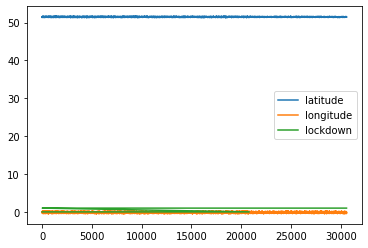

In [28]:
CRIME.plot();

In [29]:
# turn the flat data into a spatial - make the lat and long into geometry column
crime_spatial = gpd.GeoDataFrame(CRIME, geometry=gpd.points_from_xy(CRIME.longitude, CRIME.latitude))
search_spatial = gpd.GeoDataFrame(all_seraches, geometry=gpd.points_from_xy(all_seraches.longitude, all_seraches.latitude))

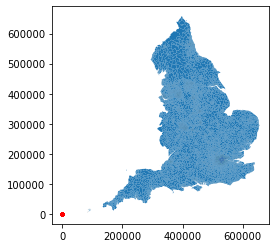

In [30]:
base = IMD.plot()

search_spatial.plot(ax = base,  marker='o', color='red', markersize=5);


In [31]:
# fix the coordinates
IMD.crs # is BNG
#search_spatial.crs
crime_spatial.crs = wgs84 
search_spatial.crs = wgs84 # assign wgs
crime_spatial = crime_spatial.to_crs(bng)
search_spatial = search_spatial.to_crs(bng) # transform to bng

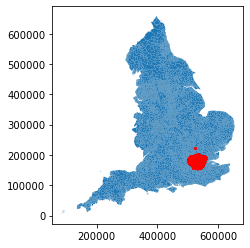

In [32]:
base = IMD.plot()

search_spatial.plot(ax = base,  marker='o', color='red', markersize=5);


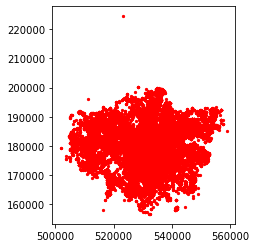

In [33]:
search_spatial.plot(  marker='o', color='red', markersize=5);

In [34]:
# get the information about the IMD to stop and search
search_ready_model_base = gpd.sjoin(search_spatial, IMD, how ='left' , op='intersects')
crime_ready_model_base = gpd.sjoin(crime_spatial, IMD, how ='left' , op='intersects')
search_ready_model_base.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 46412 entries, 0 to 30582
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   type                       46412 non-null  object  
 1   latitude                   46412 non-null  float64 
 2   longitude                  46412 non-null  float64 
 3   gender                     45765 non-null  object  
 4   age_range                  42185 non-null  object  
 5   self-defined_ethnicity     45762 non-null  object  
 6   officer-defined_ethnicity  45486 non-null  object  
 7   object_of_search           46305 non-null  object  
 8   outcome                    46412 non-null  object  
 9   lockdown                   46412 non-null  int64   
 10  geometry                   46412 non-null  geometry
 11  index_right                46358 non-null  float64 
 12  lsoa11cd                   46358 non-null  object  
 13  LADcd                  

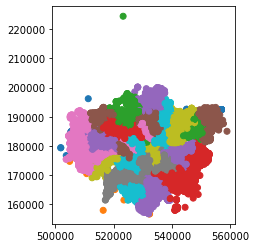

In [35]:
search_ready_model_base.plot(column='LADcd'); 

In [36]:
# there is an outlier 

### 6. Groupby to get ready for first model

In [37]:
# first select the columns for modelling
SS1 = pd.DataFrame(search_ready_model_base).loc[:,['lsoa11cd','IMDScore','EmpScore','EduScore','HDDScore','CriScore','EnvScore','CYPScore','TotPop','Pop16_59','WorkPop','lockdown']]
# groupby all variables lsoa and lockdown
search_model1 = SS1.groupby(['lsoa11cd', 'lockdown']).agg(['mean'])
# groupby rows by lsoa and lockdown
SS3 = SS1[['lsoa11cd','lockdown','WorkPop']].groupby(['lsoa11cd','lockdown']).agg(['count'])
# get 
search_model1['count_search'] = SS3
search_model1 = search_model1.reset_index()

In [38]:
# first select the columns for modelling
SS1 = pd.DataFrame(crime_ready_model_base).loc[:,['lsoa11cd','IMDScore','EmpScore','EduScore','HDDScore','CriScore','EnvScore','CYPScore','TotPop','Pop16_59','WorkPop','lockdown']]
# groupby all variables lsoa and lockdown
search_model2 = SS1.groupby(['lsoa11cd', 'lockdown']).agg(['mean'])
# groupby rows by lsoa and lockdown
SS3 = SS1[['lsoa11cd','lockdown','WorkPop']].groupby(['lsoa11cd','lockdown']).agg(['count'])
# get 
search_model2['count_search'] = SS3
search_model2 = search_model2.reset_index()

In [39]:
search_model1.head() # all stops 

,lsoa11cd,lockdown,IMDScore,EmpScore,EduScore,HDDScore,CriScore,EnvScore,CYPScore,TotPop,Pop16_59,WorkPop,count_search
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,
0,E01000005,0,28.652,0.136,22.260,-0.121,-1.317,28.979,0.338,1121.0,692.0,683.0,6
1,E01000005,1,28.652,0.136,22.260,-0.121,-1.317,28.979,0.338,1121.0,692.0,683.0,8
2,E01000006,0,19.837,0.059,14.798,-0.359,-0.147,26.888,-0.366,2040.0,1297.0,1284.5,1
3,E01000006,1,19.837,0.059,14.798,-0.359,-0.147,26.888,-0.366,2040.0,1297.0,1284.5,14
4,E01000007,0,31.576,0.107,11.385,-0.027,0.846,25.995,-0.133,2101.0,1424.0,1404.0,7


In [40]:
search_model2.head() # stops with an outcomes

,lsoa11cd,lockdown,IMDScore,EmpScore,EduScore,HDDScore,CriScore,EnvScore,CYPScore,TotPop,Pop16_59,WorkPop,count_search
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,
0,E01000005,1,28.652,0.136,22.260,-0.121,-1.317,28.979,0.338,1121.0,692.0,683.0,2
1,E01000006,1,19.837,0.059,14.798,-0.359,-0.147,26.888,-0.366,2040.0,1297.0,1284.5,3
2,E01000007,1,31.576,0.107,11.385,-0.027,0.846,25.995,-0.133,2101.0,1424.0,1404.0,2
3,E01000008,0,37.596,0.151,25.506,0.250,0.353,30.233,0.129,1566.0,961.0,939.5,6
4,E01000008,1,37.596,0.151,25.506,0.250,0.353,30.233,0.129,1566.0,961.0,939.5,4


## EDA

### Stop & Search

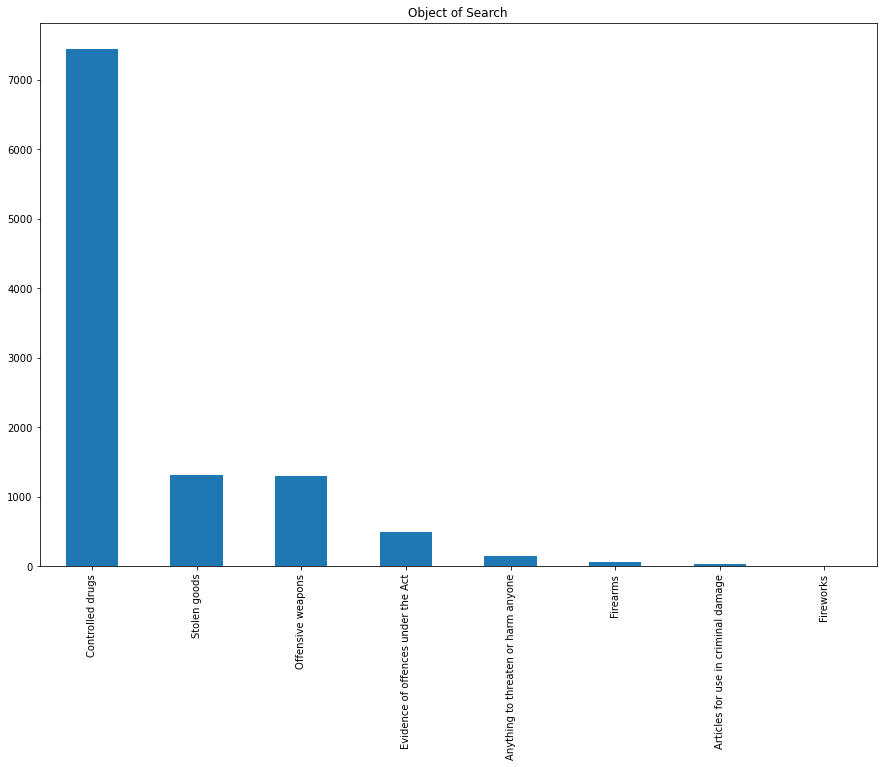

In [41]:
CRIME.object_of_search.value_counts().plot.bar(title='Object of Search',figsize=(15,10));

### IMD

In [42]:
#search_model1.plot('IMDScore');

In [43]:
#search_model2.plot(column='IMDScore');

### Modelling data

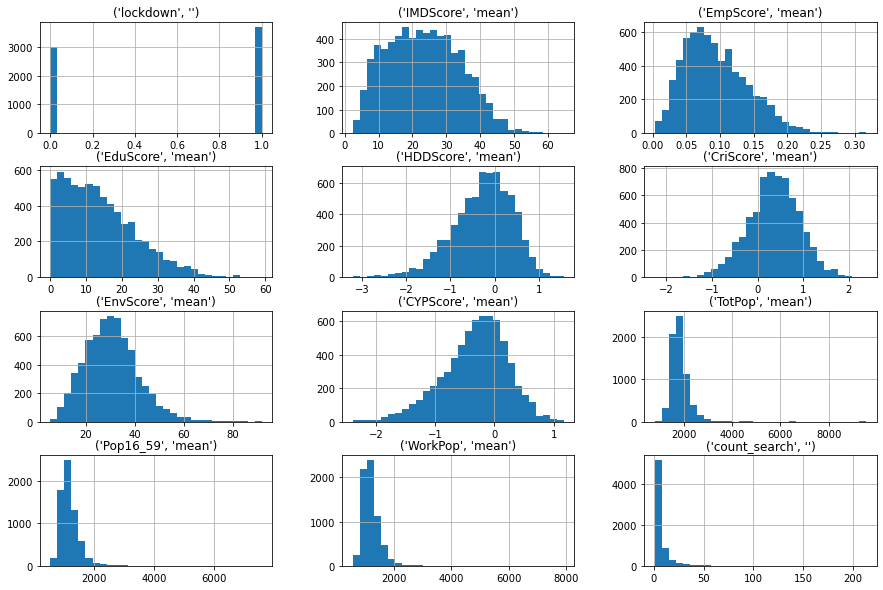

In [44]:
search_model1.hist(bins=30, figsize=(15, 10));

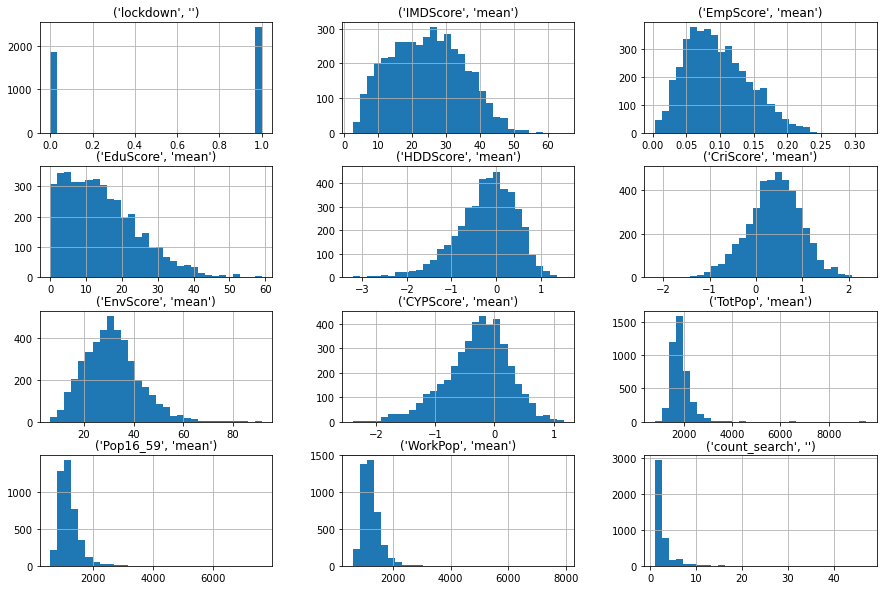

In [45]:
search_model2.hist(bins=30, figsize=(15, 10));

## T-test

In [46]:
## Calculate the t-statistics
# all searches
var_a = search_model1['count_search'].loc[search_model1['lockdown']==1,]
var_b = search_model1['count_search'].loc[search_model1['lockdown']==0,]

# searches with outcome only
var_a_o = search_model2['count_search'].loc[search_model2['lockdown']==1,]
var_b_o = search_model2['count_search'].loc[search_model2['lockdown']==0,]
var_b.head()


0     6
2     1
4     7
6    19
8    24
Name: count_search, dtype: int64

In [47]:
var_b.count() # all searches

3018

In [48]:
var_b_o.count() # searches with outcome

1842

In [49]:
# all searches
summary_a, results_a = rp.ttest(group1= var_a, group1_name= "lockdown", group2= var_b, group2_name= "no_lockdown")
print(summary_a)
print(results_a)

      Variable       N      Mean         SD        SE  95% Conf.  Interval
0     lockdown  3682.0  7.485606  10.478419  0.172685   7.147039  7.824173
1  no_lockdown  3018.0  6.227966  10.550589  0.192051   5.851401  6.604530
2     combined  6700.0  6.919104  10.528816  0.128630   6.666949  7.171260
                       Independent t-test    results
0  Difference (lockdown - no_lockdown) =      1.2576
1                   Degrees of freedom =   6698.0000
2                                    t =      4.8728
3                Two side test p value =      0.0000
4               Difference < 0 p value =      1.0000
5               Difference > 0 p value =      0.0000
6                            Cohen's d =      0.1197
7                            Hedge's g =      0.1196
8                        Glass's delta =      0.1200
9                                    r =      0.0594


In [50]:
# searches with outcome only
summary, results = rp.ttest(group1= var_a_o, group1_name= "lockdown", group2= var_b_o, group2_name= "no_lockdown")
print(summary)
print(results)

      Variable       N      Mean        SD        SE  95% Conf.  Interval
0     lockdown  2412.0  2.631841  2.684817  0.054667   2.524641  2.739040
1  no_lockdown  1842.0  2.435396  3.215999  0.074933   2.288434  2.582358
2     combined  4254.0  2.546780  2.927937  0.044891   2.458769  2.634790
                       Independent t-test    results
0  Difference (lockdown - no_lockdown) =      0.1964
1                   Degrees of freedom =   4252.0000
2                                    t =      2.1692
3                Two side test p value =      0.0301
4               Difference < 0 p value =      0.9849
5               Difference > 0 p value =      0.0151
6                            Cohen's d =      0.0671
7                            Hedge's g =      0.0671
8                        Glass's delta =      0.0732
9                                    r =      0.0332


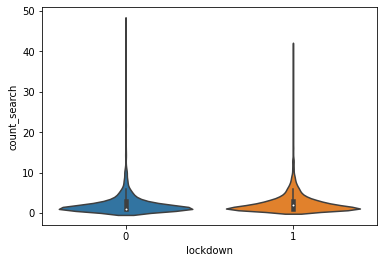

In [51]:
# with outcomes only
sns.violinplot( y=search_model2['count_search'], x=search_model2['lockdown'] );


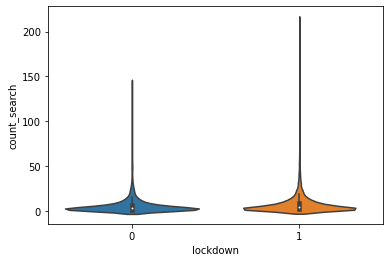

In [52]:
# all stops 
sns.violinplot( y=search_model1['count_search'], x=search_model1['lockdown'] );

In [53]:
#0 = 2019
#1= 2020

## Poisson regression

X ~ Y + Z

In [54]:
# define lockdown as categorical variable
search_model1['lock_cat'] = np.where(search_model1['lockdown']==1, 'YES', 'NO')
search_model2['lock_cat'] = np.where(search_model2['lockdown']==1, 'YES', 'NO')
search_model1.head()

,lsoa11cd,lockdown,IMDScore,EmpScore,EduScore,HDDScore,CriScore,EnvScore,CYPScore,TotPop,Pop16_59,WorkPop,count_search,lock_cat
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,,
0,E01000005,0,28.652,0.136,22.260,-0.121,-1.317,28.979,0.338,1121.0,692.0,683.0,6,NO
1,E01000005,1,28.652,0.136,22.260,-0.121,-1.317,28.979,0.338,1121.0,692.0,683.0,8,YES
2,E01000006,0,19.837,0.059,14.798,-0.359,-0.147,26.888,-0.366,2040.0,1297.0,1284.5,1,NO
3,E01000006,1,19.837,0.059,14.798,-0.359,-0.147,26.888,-0.366,2040.0,1297.0,1284.5,14,YES
4,E01000007,0,31.576,0.107,11.385,-0.027,0.846,25.995,-0.133,2101.0,1424.0,1404.0,7,NO


In [55]:
# define training and tsting dataset # all searches
mask = np.random.rand(len(search_model1)) < 0.8
search_train = search_model1[mask]
search_test = search_model1[~mask]

In [56]:
mask2 = np.random.rand(len(search_model2)) < 0.8
search_train2 = search_model2[mask2]
search_test2 = search_model2[~mask2]

In [57]:
# poisson regression

expr = """count_search ~ lock_cat + IMDScore"""

y_train, X_train = dmatrices(expr, search_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, search_test, return_type='dataframe')

# poisson regression

expr2 = """count_search ~ lock_cat + IMDScore"""

y_train2, X_train2 = dmatrices(expr2, search_train2, return_type='dataframe')
y_test2, X_test2 = dmatrices(expr2, search_test2, return_type='dataframe')

In [58]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           count_search   No. Observations:                 5378
Model:                            GLM   Df Residuals:                     5375
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29680.
Date:                Tue, 27 Apr 2021   Deviance:                       41878.
Time:                        19:44:08   Pearson chi2:                 7.45e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1653      0.015     

In [59]:
poisson_training_results2 = sm.GLM(y_train2, X_train2, family=sm.families.Poisson()).fit()
print(poisson_training_results2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           count_search   No. Observations:                 3445
Model:                            GLM   Df Residuals:                     3442
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7416.1
Date:                Tue, 27 Apr 2021   Deviance:                       6001.0
Time:                        19:44:08   Pearson chi2:                 9.96e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4853      0.031     

In [60]:
search_model1.IMDScore.describe()

,mean
count,6700.000000
mean,23.447490
std,10.740619
min,2.326000
25%,14.852250
50%,23.035000
75%,31.361250
max,64.677000


# Predict

In [64]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean   mean_se  mean_ci_lower  mean_ci_upper
2     5.453576  0.047997       5.360310       5.548465
5     8.864286  0.064280       8.739191       8.991172
6     8.772678  0.083470       8.610595       8.937812
9     9.170319  0.068679       9.036694       9.305920
10    7.641139  0.064861       7.515066       7.769326
...        ...       ...            ...            ...
6667  4.990378  0.050762       4.891872       5.090868
6671  9.345519  0.071393       9.206634       9.486499
6674  4.109199  0.048157       4.015888       4.204677
6687  5.042343  0.050602       4.944134       5.142503
6694  6.432940  0.047846       6.339844       6.527403

[1322 rows x 4 columns]


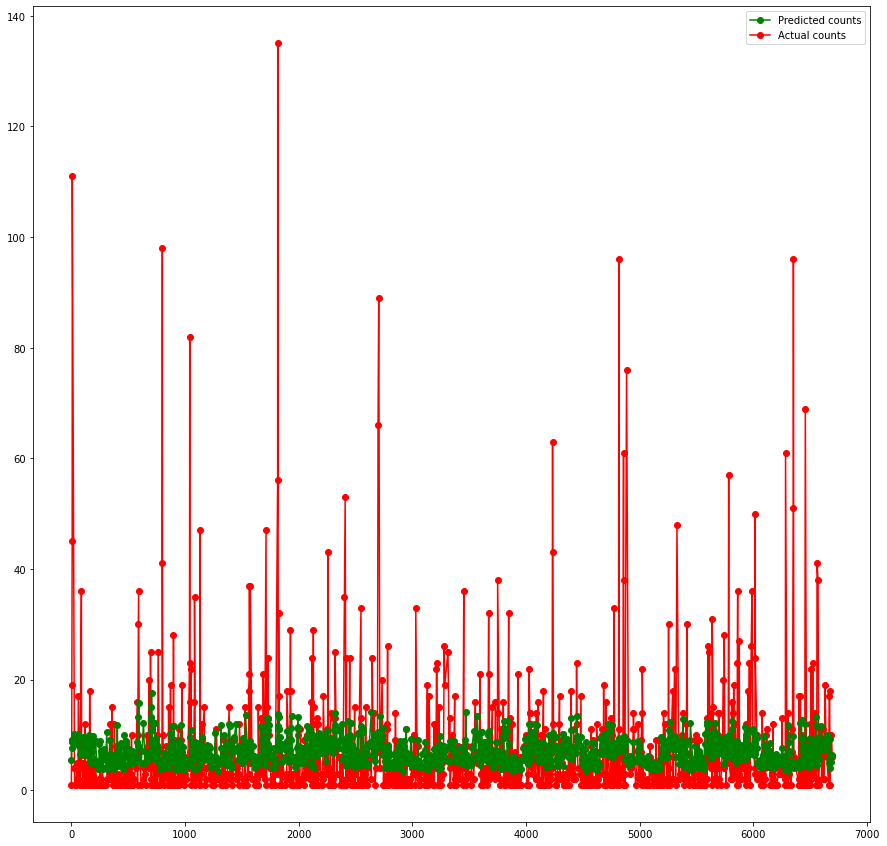

In [65]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['count_search']
fig = plt.figure(figsize=(15,15))
#fig.suptitle('Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')

plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

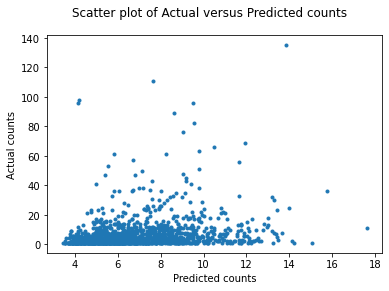

In [63]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()